In [113]:
pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [114]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import random
import time

#Sklearn methods
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score
#Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


**Data Import**

In [115]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
dataFrame = cdc_diabetes_health_indicators.data.features
dataFrame["target"] = cdc_diabetes_health_indicators.data.targets

C:\Users\juanr\AppData\Local\Temp\ipykernel_14252\1715581692.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame["target"] = cdc_diabetes_health_indicators.data.targets


**Data Cleaning**

After the data analysis is possible to identify the following actions to implement in the data.
1. Data normalization: Currently there are predictors with binary values and others with numbers between 0 and 30, this will generate a bad behavior in the analysis and future model implementation.
2. Outliers identification: it's necessary to evaluate if predictors like Age, Income, BMI are in valid ranges, in case these values are out of valid number, that row will be excluded.
3. Predictors exclusion: As part of the data analysis process, it was possible to see that there is a big correlation (0.45) between Education and Income, for this case the Education predictor will be excluded from the data.
4. Null values: For this case, records with null values will be removed from the data.

In [116]:
#Normalization using min max technique
def min_max_normalization(input_array):
    max_value = np.max(input_array)
    min_value = np.min(input_array)
    normalized_result = np.zeros(len(input_array))
    for i, element in enumerate(input_array):
        normalized_result[i] = round((element - min_value)/(max_value-min_value),3)

    return normalized_result

In [117]:
#Removing outliers
def removing_outliers(dataFrame, predictor, min_value, max_value):
     return dataFrame[(dataFrame[predictor] > min_value) & (dataFrame[predictor] < max_value)]

**Removing outliers**

In [118]:
# Removing outliers
dataFrame = removing_outliers(dataFrame,'Age', 0, 100) #Evaluates no negative age and not over 100 years old
dataFrame = removing_outliers(dataFrame,'BMI', 13, 52) #BMI can be between 13 - Underwieght limit and 52 - Morbidly Obese

**Normalization**

This data has a mix between scales in ages, BMI, and scores between 5-1 and 1-6, it is necessary to make a normalization so everything can be in the same scale. 
For this a min_max_normalization is implemented so all values will be between 0 and 1.


In [119]:
#Bec
dataFrame['Age'] = min_max_normalization(dataFrame['Age'])
dataFrame['BMI'] = min_max_normalization(dataFrame['BMI'])
dataFrame['GenHlth'] = min_max_normalization(dataFrame['GenHlth'])
dataFrame['MentHlth'] = min_max_normalization(dataFrame['MentHlth'])
dataFrame['PhysHlth'] = min_max_normalization(dataFrame['PhysHlth'])
dataFrame['Education'] = min_max_normalization(dataFrame['Education'])
dataFrame['Income'] = min_max_normalization(dataFrame['Income'])

dataFrame.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,target
0,1,1,1,0.703,1,0,0,0,0,1,...,0,1.00,0.6,0.5,1,0,0.667,0.6,0.286,0
1,0,0,0,0.297,1,0,0,1,0,0,...,1,0.50,0.0,0.0,0,0,0.500,1.0,0.000,0
2,1,1,1,0.378,0,0,0,0,1,0,...,1,1.00,1.0,1.0,1,0,0.667,0.6,1.000,0
3,1,0,1,0.351,0,0,0,1,1,1,...,0,0.25,0.0,0.0,0,0,0.833,0.4,0.714,0
4,1,1,1,0.270,0,0,0,1,1,1,...,0,0.25,0.1,0.0,0,0,0.833,0.8,0.429,0


**Visualize Correlation Matrix After Normalization**

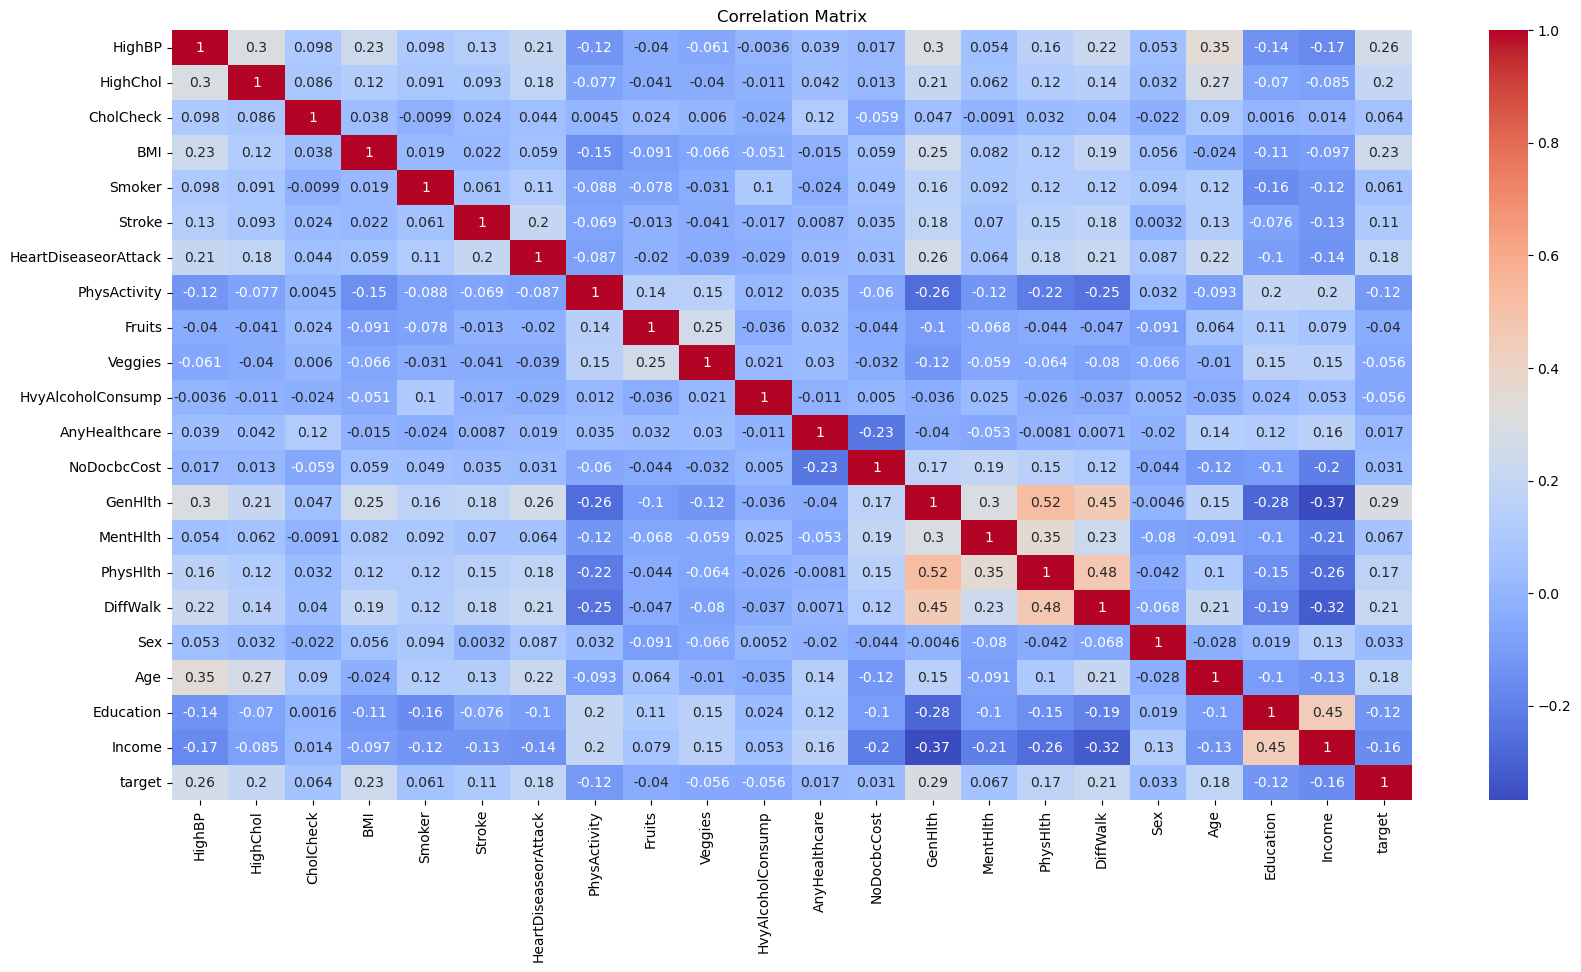

In [120]:
# Visualize correlations 
plt.figure(figsize=(20, 10))
sns.heatmap(dataFrame.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Predictors exclusion**

From the processed data we can see some high correlations:
1. There is a high correlation of 45%, betweent Income and Education, so for this case we will remove the Income feature to reduce dependencies between tese variables.
2. There is high correlation of 52% between Physical Health and General Health, also checking the correlation between other variables, it is possible to identify that GenHealth has less correlation with other features in comparison to Physical health, so for this implementation we will remove physical health from the data.
3. There is a high correlation of 44% between, DiffWalk and GenHealth, also a high correlation between DiffWalk and PhysHlth. For this case and knowing that PhyHealth has removed, for this case GenHealth will be removed.

In [121]:
dataToProcess = dataFrame.drop(['Income', 'PhysHlth', 'GenHlth'], axis=1)

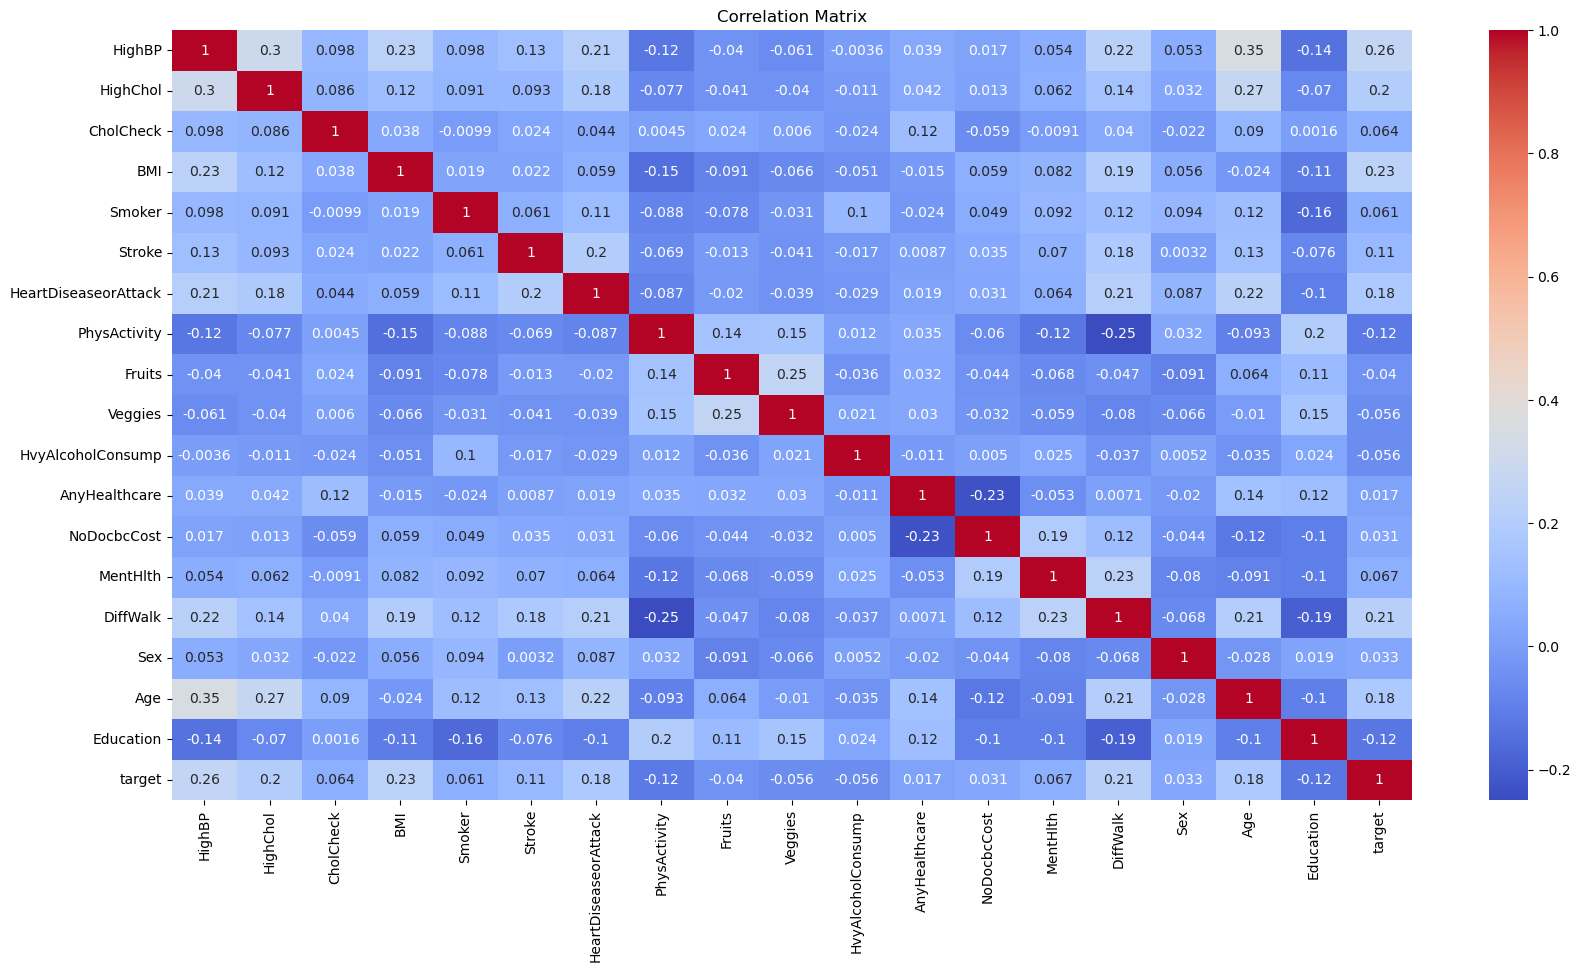

In [122]:
plt.figure(figsize=(20, 10))
sns.heatmap(dataToProcess.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Removing nulls and Empty records**

In [123]:
print("Total number of records in the frame: ", dataToProcess.count())

Total number of records in the frame:  HighBP                  251731
HighChol                251731
CholCheck               251731
BMI                     251731
Smoker                  251731
Stroke                  251731
HeartDiseaseorAttack    251731
PhysActivity            251731
Fruits                  251731
Veggies                 251731
HvyAlcoholConsump       251731
AnyHealthcare           251731
NoDocbcCost             251731
MentHlth                251731
DiffWalk                251731
Sex                     251731
Age                     251731
Education               251731
target                  251731
dtype: int64


In [124]:
#number of null values per column
dataToProcess.isnull().sum()

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
MentHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
target                  0
dtype: int64

In [125]:
#number of No value NaN per column
dataToProcess.isna().sum()

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
MentHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
target                  0
dtype: int64

**Data Processing**

After processing and analyzing the data, I will folllow the next steps to start implementing a prediction model. The objective is to test three models to find the best response of each of this models. These are the steps that will be implemented:

1. Data Split:
   The data will be splited into Train data taking 70% of the records and Test data with 30% of the records.
2. Machine learning Model implementation:
   - K-nearest neighboors.
   - Ridge regression.
   - Decision tree classifier.
   - Random Forest Classifier.
3. Cross validation and Hyperparameter tunning
4. Model validation and Final performance metrics.
5. Conclusion

**Spliting data**

In [126]:
y = dataToProcess['target']
X = dataToProcess.drop('target', axis=1)


# Configuration of train and test dataset
# X: input data without target data
# y: target data (output)
# train_size: proportion of data to the training dataset. For this case was considered 70%.
# test_size: proportion of data to the training dataset. For this case was considered 30%.
#randome_state: Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7, 
                                                    test_size=0.3, 
                                                    random_state=random.randint(0, 42), 
                                                    shuffle=True)

**Machine Learning Model Implementation**

In [127]:
#Models to evaluate
models = {
    'k-NN': KNeighborsClassifier(),
    'Ridge': RidgeClassifier(), 
    'DecisionTree': DecisionTreeClassifier()
}

In [128]:
# Training and model evaluation
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")

k-NN: RMSE = 0.3918, R2 = -0.2917
Ridge: RMSE = 0.3683, R2 = -0.1415
DecisionTree: RMSE = 0.4362, R2 = -0.6011


Error analysis:
- **K-nearest neighboors**: From the error analysis, it is possible to see a RMSE: 0.3924 with a R2: -0.2938, this shows a poor fit of the model ussing default input parameters.
- **Rigde regression Classifier**: From the error analysis, it is possible to see a RMSE = 0.3697 with a R2: -0.1482, this shows a poor fit of the model ussing default input parameters.
- **Random forest classifier**: From the error analysis, it is possible to see a RMSE = 0.3904 with a R2: -0.2805, this shows a poor fit of the model ussing default input parameters.
- **Decision tree Classifier**: From the error analysis, it is possible to see a RMSE = 0.4330 with a R2: -0.5753

From these results it is possible to consider that the model that performed the best is the **Decision tree Classifier**, but still with some poor data, having a 57.5% of fit to the model still is necessary to improve parameters values to get a better performance.


**Grid Search Implementation**

As a first approach a grid seach implementation to find the best combination is taken into consideration to measure the best combinations of input paramters. Although this is a simple method, for this simple exercise it takes more than 9 hours to process the correct values.

In [112]:
# Define the parameter grid for Ridge, Lasso, and Elastic Net
k_nn_weights = ['uniform','distance']
k_nn_algorithm = ['auto','ball_tree', 'kd_tree', 'brute']
k_nn_leaf_size = [1,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30];
k_nn_p = [1,2]

best_score = 0;
best_rmse = 1;
best_model = {'weight': 0, 'algorithm': '', 'leaf_size': 0, 'p': 0}

start_time = time.time()
for weight_value in k_nn_weights:
    for algo_value in k_nn_algorithm:
        for leaf_size in k_nn_leaf_size:
            for p in k_nn_p:
                model = KNeighborsClassifier(weights=weight_value, algorithm=algo_value, leaf_size=leaf_size, p=p)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                r2 = r2_score(y_test, y_pred)
                if (abs(r2) > best_score and abs(rmse) < best_rmse):
                    best_score = r2
                    best_rmse = rmse
                    best_model['weight'] = weight_value
                    best_model['algorithm'] = algo_value
                    best_model['leaf_size'] = leaf_size
                    best_model['p'] = p

end_time = time.time();
elapsed_time = end_time - start_time
print(f"{'KNeighborsClassifier'}: RMSE = {best_rmse:.4f}, R2 = {best_score:.4f}, weights: {best_model['weight']}, algorithm: {best_model['algorithm'] }, leaf_size:{best_model['leaf_size']}, p:{best_model['p']} ")
print(f"Elapsed time: {elapsed_time:.4f} seconds")


KeyboardInterrupt: 

**Cross Validation and Hyperparameter tunning**

In [ ]:
param_grid = {
    'k-NN': {'n_neighbors': [10], 'weights': ['distance'], 'algorithm': ['ball_tree'], 'leaf_size': [40], 'p': [2]},
    'Ridge': {'alpha': [0.1, 1.0, 10.0, 100.0]},
    'DecisionTree': {'criterion': 'entropy', 'splitter': 'best', 'max_features': 21.0 }
}

# Perform cross-validation and hyperparameter tuning
best_models = {}
for name, model in models.items():
    if name in param_grid:
        grid = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_mean_squared_error')
        grid.fit(X_train, y_train)
        best_models[name] = grid.best_estimator_
        best_rmse = np.sqrt(-grid.best_score_)
        print(f"Best {name}: {grid.best_params_}, RMSE = {best_rmse:.4f}")
    else:
        # For Linear Regression, just perform cross-validation
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)  # Convert negative MSE to RMSE
        best_models[name] = model
        print(f"{name}: Cross-validation RMSE = {rmse_scores.mean():.4f}")

print()
print('Evaluate the best models on the test set')
results = {}
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")